In [21]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpb = tfp.bijectors

from stingray import Lightcurve
from stingray.modeling.gpmodeling import (
    get_prior,
    get_gp_params,
    get_log_likelihood,
    GPResult,
    run_posterior_check,
    run_prior_checks,
)

plt.style.use(
    "https://github.com/mlefkir/beauxgraphs/raw/main/beautifulgraphs_colblind.mplstyle"
)

First, let's load the time series

In [22]:
t,y,yerr = np.genfromtxt("simu_12.txt", unpack=True)

[Text(0.5, 0, 'Time (d)'), Text(0, 0.5, 'Value')]

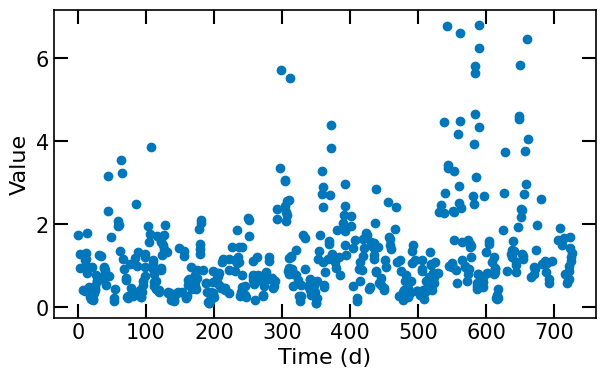

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(t, y, yerr=yerr, fmt="o")
ax.update({"xlabel": "Time (d)", "ylabel": "Value"})

### Define the model

Define the power spectrum model, here a simple bending power-law of the form:
\begin{equation}
P(f) = \frac{(f/f_1)^{-\alpha_1}}{1 + (f/f_1)^{\alpha_2-\alpha_1}}
\end{equation}
where $f_1$ is the bending frequency, $\alpha_1$ is the low-frequency slope, and $\alpha_2$ is the high-frequency slope.

In [24]:
kernel_type = "PowL"

Choose a mean function for the process, here a constant mean

In [25]:
mean_type = "constant"

Get the parameters of this model, note that we can also have a scale parameter on the errors with the option `error_scale=True`. If the values in the time series are log-normally distributed, then we can use the option `log_transform=True` to model a possibly shifted log-normal distribution of fluxes.

In [26]:
kernel_params = get_gp_params(kernel_type, mean_type)
print(f"parameters: {kernel_params}")
kernel_params = get_gp_params(
    kernel_type, mean_type, scale_errors=True, log_transform=True
)
print(f"parameters : {kernel_params}")

parameters: ['alpha_1', 'log_f_bend', 'alpha_2', 'variance', 'log_A']
parameters : ['alpha_1', 'log_f_bend', 'alpha_2', 'variance', 'A', 'scale_err', 'log_shift']


Obtain the log likelihood of the model

In [27]:
loglike = get_log_likelihood(kernel_params,kernel_type,mean_type,t,y,yerr)

### Define the priors

Here we define the prior distributions for the parameters of the model using tensorflow_probability distributions.

In [28]:
f_min = 1 / (t.max() - t.min())
f_max = 1 / (2 * np.min(np.diff(t)))
min_f_1, max_f_1 = f_min * 4, f_max / 4
muL = jnp.log(np.var(y)) - 0.5

priors = [
    tfpd.Uniform(low=0.0, high=1.25),
    tfpd.Uniform(low=jnp.log(min_f_1), high=jnp.log(max_f_1)),
    tfpd.Uniform(low=1.5, high=4),
    tfpd.LogNormal(muL, 1.0),
    tfpd.Normal(0.0, 2),
    tfpd.Gamma(
        jnp.array(2.0), jnp.array(2.0)
    ),  # was not working without jnp.array, why?
    tfpd.Uniform(low=jnp.log(1e-6), high=jnp.log(0.99 * jnp.min(y))),
]

prior_dict = dict(zip(kernel_params, priors))
prior_model = get_prior(kernel_params, prior_dict)

To check that the approximation of the bending power-law with celerite basis functions is correct with the defined priors, we can use the `run_prior_checks` function as follows:

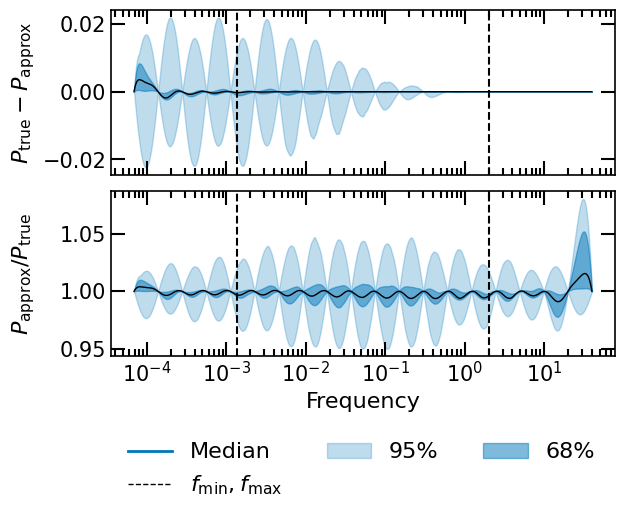

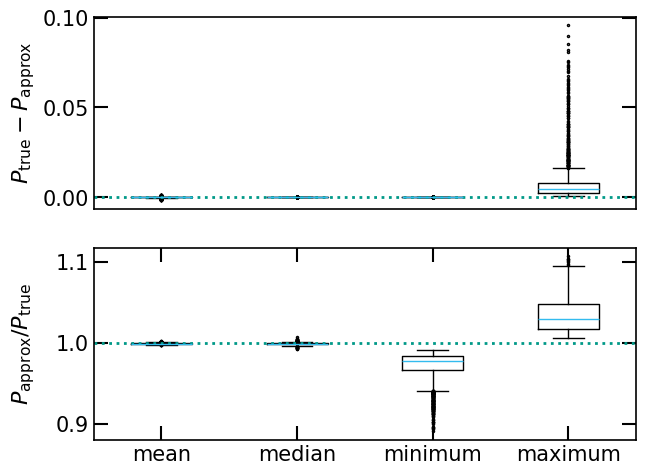

In [29]:
fig1, fig2 = run_prior_checks(kernel_type,kernel_params,priors,loglike,f_min,f_max)

### Sample the posterior distribution

Define the light curve and the GP model

In [30]:
lc = Lightcurve(t,y,err=yerr,err_dist='gauss')
gp = GPResult(lc)

/home/mehdy/github/stingray/stingray/utils.py:484: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mehdy/github/stingray/stingray/utils.py:484: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Sample the posterior distribution with nested sampling using the jaxns library (takes about 40 min)

In [16]:
gp.sample(prior_model,loglike)

In [ ]:
# np.savetxt("posterior_samples_12.txt",np.array(list(gp.results.samples.values())))
# posterior_samples = np.genfromtxt("posterior_samples_12.txt")
posterior_dict = dict(zip((sorted(kernel_params)),posterior_samples))
params = ["alpha_1", "f_bend", "alpha_2", "variance", "scale_err", "A", "shift"]

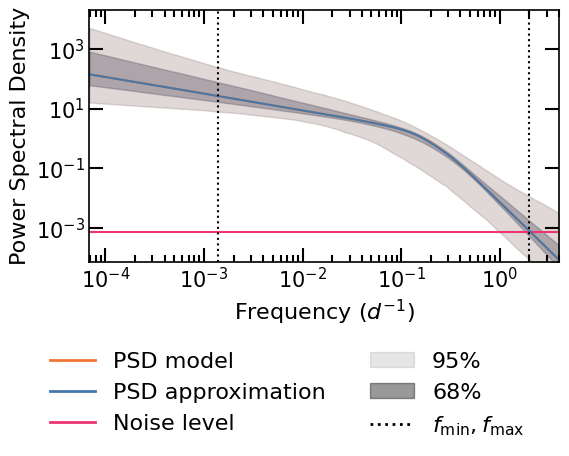

In [33]:
run_posterior_check(kernel_type,kernel_params,posterior_dict,t,y,yerr)